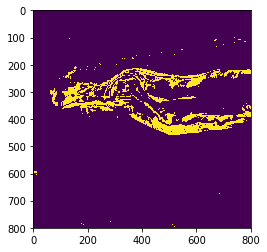

In [1]:
import cv2
import numpy as np
import dippykit as dip
import matplotlib.pyplot as plt
import pandas as pd


#PICKING AN IMAGE
im_original = cv2.imread("images/UW_400.png")
#im_original = cv2.imread("images/underwater-15.png")

#im_original = cv2.imread("images/24Zimmer-Refer-articleLarge.jpg")

#INITIAL EXPLORATION OF THE PICTURE

#Select pixels that are similar in color to skin
im_skin = np.copy(im_original)
for i in range(np.shape(im_original)[0]):
    for j in range(np.shape(im_original)[1]):
        #if im_original[i,j][2] < 60:
        if im_original[i,j][2] < 60 or im_original[i,j][0] > 200: #Zones mostly reddish, not blueish
            im_skin[i,j]=[0,0,0]

cv2.imwrite("temp_images/skin_color.png", im_skin)

#Select zones with high luminosity (probably zones iluminated by refracted light)
im_gray = cv2.cvtColor(im_original, cv2.COLOR_BGR2GRAY)
ret,th1 = cv2.threshold(im_gray,180,255,cv2.THRESH_BINARY)

cv2.imwrite("temp_images/binary.png", th1)

#Saliency detection
# initialize OpenCV's static fine grained saliency detector and compute the saliency map
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(im_original)

# if we would like a *binary* map that we could process for contours,
# compute convex hull's, extract bounding boxes, etc., we can
# additionally threshold the saliency map

threshMap = cv2.threshold(saliencyMap*255, 80, 255,cv2.THRESH_BINARY)[1]

cv2.imwrite("temp_images/saliency.png", saliencyMap*255)


%matplotlib inline
dip.imshow(threshMap)
dip.show()


In [2]:
class Pixel(object):
    def __init__(self):
        self.position = None
        self.neighbors = None

In [3]:
#Interpolation 

im_skin_interp = np.copy(im_skin)

#Step 1: Go over all the pixels of "Zones similar to skin color" using a square of 4 pixels

for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        
        pixel_upper_left = im_skin[i,j]
        pixel_upper_rigth = im_skin[i,j+1]
        pixel_bottom_left = im_skin[i+1 ,j]
        pixel_bottom_rigth = im_skin[i+1,j+1]
        
        pixel_array = [pixel_upper_left, pixel_upper_rigth, pixel_bottom_left, pixel_bottom_rigth]
        
        remove_pixel = [False, False, False, False]
        
                
        #Step 2: Check if at least one of the 4 pixels correspond to the body (i.e. it isn´t black)
        
        if (pixel_upper_left > ([0, 0, 0])).all() or (pixel_upper_rigth > ([0,0,0])).all or (pixel_bottom_left > ([0,0,0])).all() or (pixel_bottom_rigth > ([0,0,0])).all():
            
            #Step 3: Check if any of those pixels are marked as pixels to remove (i.e. they are white on image after binary threshold)
            if th1[i,j] == 255: 
                remove_pixel[0] = True
            if th1[i,j+1] == 255: 
                remove_pixel[1] = True
            if th1[i+1,j] == 255: 
                remove_pixel[2] = True
            if th1[i+1,j+1] == 255: 
                remove_pixel[3] = True
            
            #We need to remove the targeted pixels and substitute its value with the average of the surrounding pixels that are part of the body
            
            aux_pixel_value = [0,0,0]
            num_pixels_for_average = 0
            
            for p in range(np.shape(pixel_array)[0]):
                #if remove_pixel[p] == False and (pixel_array[p] > ([0, 0, 0])).all(): 
                if remove_pixel[p] == False: #Using this condition, the image has less false skin-coloured pixels
                    aux_pixel_value = aux_pixel_value + pixel_array[p]
                    num_pixels_for_average = num_pixels_for_average + 1
                    
            if num_pixels_for_average > 0: 
                avg_pixel_value = aux_pixel_value/num_pixels_for_average
            elif num_pixels_for_average == 0:
                avg_pixel_value = (255,0,0)
                
            
            for p in range(np.shape(pixel_array)[0]):
                if remove_pixel[p] == True: 
                    pixel_array[p] =  avg_pixel_value
                    
            if (im_skin[i,j] == [0,0,0]).all():
                im_skin_interp[i,j] = pixel_array[0]
            if (im_skin[i,j+1] == [0,0,0]).all():
                im_skin_interp[i,j+1] = pixel_array[1]
            if (im_skin[i+1,j] == [0,0,0]).all():
                im_skin_interp[i+1 ,j] = pixel_array[2]
            if (im_skin[i+1,j+1] == [0,0,0]).all():
                im_skin_interp[i+1,j+1] = pixel_array[3]
            
            
cv2.imwrite("temp_images/skin_color_interpolated.png", im_skin_interp)           
            


True

In [4]:
#list_pixel_first_order = list(range(0, np.shape(im_original)[0]*np.shape(im_original)[1]))
list_pixels_to_fix = []

#Adding red pixels to the list of pixels to fix
    
for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        if (im_skin_interp[i,j] == ([255,0,0])).all():
           
            list_pixels_to_fix.append((i,j))

print(list_pixels_to_fix)

[(105, 132), (105, 133), (106, 758), (106, 759), (106, 760), (106, 761), (107, 756), (107, 757), (107, 758), (107, 759), (108, 670), (108, 671), (108, 672), (108, 754), (108, 755), (108, 756), (108, 757), (109, 667), (109, 668), (109, 669), (109, 670), (110, 666), (110, 667), (110, 668), (111, 665), (111, 666), (115, 777), (115, 778), (115, 779), (116, 775), (116, 776), (116, 777), (116, 778), (117, 775), (124, 698), (124, 699), (125, 696), (125, 697), (131, 674), (132, 673), (155, 471), (156, 468), (156, 469), (156, 470), (165, 424), (165, 425), (166, 356), (166, 379), (166, 380), (167, 377), (167, 378), (167, 379), (168, 377), (168, 378), (174, 329), (174, 365), (174, 366), (175, 328), (175, 329), (175, 334), (175, 365), (175, 366), (176, 328), (176, 329), (176, 334), (176, 366), (177, 367), (180, 322), (186, 267), (186, 347), (186, 348), (187, 347), (187, 348), (196, 244), (196, 245), (197, 243), (197, 244), (197, 250), (197, 307), (197, 308), (197, 309), (197, 310), (198, 243), (19

In [5]:
num_pixel = 0

list_pixels_first_order = []

for item in list_pixels_to_fix: 
        
        # i and j are the coordinates of each red pixel
        i = item[0]
        j = item[1]
        
        initialization_pixel = 0 #That means that the pixel has not been added yet to the list of first order pixels
        
        for row in range(i-1, i+2):
            for col in range(j-1, j+2): 
                #Here it checks if some of the surrounding pixels are not equal to red (i.e. has skin color)
                if (im_skin_interp[row,col] != ([255,0,0])).all():
                    
                    if initialization_pixel == 0: 
                        #the first time, it is created a structure inside the list and the position is registered 
                        #the list of neighbors is initialized
                        list_pixels_first_order.append(num_pixel)
                        list_pixels_first_order[num_pixel] = Pixel()
                        list_pixels_first_order[num_pixel].position = (i,j)
                        list_pixels_first_order[num_pixel].neighbors = []
                        
                        initialization_pixel = 1
                        num_pixel = num_pixel + 1
                    
                    list_pixels_first_order[num_pixel-1].neighbors.append((row,col))
        
        initialization_pixel = 0       
                    
"""
if (im_skin_interp[i-1,j-1] != ([255,0,0])).all(): 
    list_pixels_to_fix[num_pixel].neighbors.append((i-1,j-1))
if (im_skin_interp[i-1,j] != ([255,0,0])).all(): 
    list_pixels_to_fix[num_pixel].neighbors.append((i-1,j))
if (im_skin_interp[i-1,j+1] != ([255,0,0])).all(): 
    list_pixels_to_fix[num_pixel].neighbors.append((i-1,j+1))
if (im_skin_interp[i,j-1] != ([255,0,0])).all(): 
    list_pixels_to_fix[num_pixel].neighbors.append((i,j-1))
if (im_skin_interp[i,j+1] != ([255,0,0])).all(): 
    list_pixels_to_fix[num_pixel].neighbors.append((i-1,j+1))
if (im_skin_interp[i+1,j-1] != ([255,0,0])).all(): 
    list_pixels_to_fix[num_pixel].neighbors.append((i+1,j-1))
if (im_skin_interp[i+1,j+1] != ([255,0,0])).all(): 
    list_pixels_to_fix[num_pixel].neighbors.append((i+1,j+1))

"""
"""
for c in range(0,num_pixel):             
    print(list_pixels_first_order[c].position)   
    #print(list_pixels_to_fix[num_pixel].neighbors)  
    
"""
print(list_pixels_first_order[0].position)
print(list_pixels_first_order[0].neighbors)


(108, 754)
[(109, 754), (109, 755)]


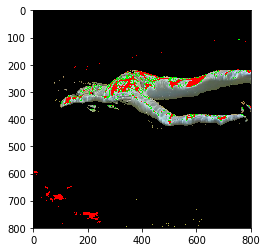

True

In [6]:
for item in list_pixels_first_order:
    # i and j are the coordinates of each first order pixel
    i = item.position[0]
    j = item.position[1]
    
    im_skin_interp[i,j] = [0, 255, 0]
    
%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()

cv2.imwrite("temp_images/skin_color_interpolated_first_order.png", im_skin_interp)

    

[289 219 131]
2
[144 109  65]
[471 349 199]
3
[157 116  66]
[462 335 183]
3
[154 111  61]
[271 192  98]
2
[135  96  49]
[85 69 33]
1
[85 69 33]
[261 226 109]
2
[130 113  54]
[196 133  70]
1
[196 133  70]
[91 82 42]
1
[91 82 42]
[151 137  70]
2
[75 68 35]
[167 186 173]
1
[167 186 173]
[330 368 342]
2
[165 184 171]
[486 539 504]
3
[162 179 168]
[470 515 487]
3
[156 171 162]
[457 493 473]
3
[152 164 157]
[455 484 470]
3
[151 161 156]
[463 486 477]
3
[154 162 159]
[508 524 493]
3
[169 174 164]
[547 557 502]
3
[182 185 167]
[580 587 506]
3
[193 195 168]
[580 585 504]
3
[193 195 168]
[784 789 654]
4
[196 197 163]
[197 196 146]
1
[197 196 146]
[354 288 269]
2
[177 144 134]
[542 446 420]
3
[180 148 140]
[463 386 368]
3
[154 128 122]
[344 290 270]
3
[114  96  90]
[1060  944  701]
6
[176 157 116]
[1256 1133  906]
7
[179 161 129]
[366 346 197]
2
[183 173  98]
[343 313 149]
2
[171 156  74]
[524 482 242]
3
[174 160  80]
[549 513 283]
3
[183 171  94]
[373 352 203]
2
[186 176 101]
[389 373 229]
2
[19

[192 170 115]
1
[192 170 115]
[391 368 301]
2
[195 184 150]
[562 559 531]
3
[187 186 177]
[378 430 455]
2
[189 215 227]
[535 579 579]
3
[178 193 193]
[784 841 841]
4
[196 210 210]
[708 768 764]
4
[177 192 191]
[739 813 841]
4
[184 203 210]
[567 620 641]
3
[189 206 213]
[ 964 1043 1078]
5
[192 208 215]
[560 641 684]
3
[186 213 228]
[334 327 313]
2
[167 163 156]
[509 439 277]
3
[169 146  92]
[681 619 483]
4
[170 154 120]
[539 511 469]
3
[179 170 156]
[167 157 143]
1
[167 157 143]
[184 167 157]
1
[184 167 157]
[544 497 468]
3
[181 165 156]
[363 365 347]
2
[181 182 173]
[200 202 211]
1
[200 202 211]
[399 403 414]
2
[199 201 207]
[199 201 203]
1
[199 201 203]
[191 192 188]
1
[191 192 188]
[380 383 374]
2
[190 191 187]
[562 570 554]
3
[187 190 184]
[548 560 541]
3
[182 186 180]
[538 553 532]
3
[179 184 177]
[549 565 540]
3
[183 188 180]
[372 383 365]
2
[186 191 182]
[376 386 369]
2
[188 193 184]
[726 732 758]
4
[181 183 189]
[571 583 591]
3
[190 194 197]
[556 583 570]
3
[185 194 190]
[367 38

[384 398 393]
2
[192 199 196]
[1124 1157 1143]
6
[187 192 190]
[725 746 734]
4
[181 186 183]
[747 765 742]
4
[186 191 185]
[579 594 568]
3
[193 198 189]
[200 205 195]
1
[200 205 195]
[198 202 190]
1
[198 202 190]
[394 402 379]
2
[197 201 189]
[394 402 379]
2
[197 201 189]
[196 200 189]
1
[196 200 189]
[381 372 333]
2
[190 186 166]
[1139 1101  989]
6
[189 183 164]
[511 517 541]
3
[170 172 180]
[155 157 141]
1
[155 157 141]
[490 496 449]
3
[163 165 149]
[360 358 348]
2
[180 179 174]
[180 176 171]
1
[180 176 171]
[533 522 506]
3
[177 174 168]
[551 562 528]
3
[183 187 176]
[342 354 337]
2
[171 177 168]
[524 552 538]
3
[174 184 179]
[1114 1181 1177]
6
[185 196 196]
[927 983 979]
5
[185 196 195]
[907 963 960]
5
[181 192 192]
[737 786 763]
4
[184 196 190]
[375 400 389]
2
[187 200 194]
[188 201 195]
1
[188 201 195]
[192 205 199]
1
[192 205 199]
[382 407 395]
2
[191 203 197]
[576 614 596]
3
[192 204 198]
[384 409 397]
2
[192 204 198]
[194 207 201]
1
[194 207 201]
[197 203 193]
1
[197 203 193]
[

[593 621 613]
3
[197 207 204]
[776 813 804]
4
[194 203 201]
[197 207 204]
1
[197 207 204]
[195 205 202]
1
[195 205 202]
[381 401 395]
2
[190 200 197]
[563 592 584]
3
[187 197 194]
[549 578 570]
3
[183 192 190]
[544 573 565]
3
[181 191 188]
[547 576 567]
3
[182 192 189]
[556 585 576]
3
[185 195 192]
[570 599 590]
3
[190 199 196]
[782 822 810]
4
[195 205 202]
[791 831 818]
4
[197 207 204]
[588 619 606]
3
[196 206 202]
[578 609 593]
3
[192 203 197]
[562 594 575]
3
[187 198 191]
[746 790 761]
4
[186 197 190]
[200 211 204]
1
[200 211 204]
[343 366 360]
2
[171 183 180]
[877 933 920]
5
[175 186 184]
[764 806 805]
4
[191 201 201]
[895 946 956]
5
[179 189 191]
[592 644 642]
3
[197 214 214]
[193 210 212]
1
[193 210 212]
[575 626 633]
3
[191 208 211]
[767 837 841]
4
[191 209 210]
[385 421 420]
2
[192 210 210]
[194 212 211]
1
[194 212 211]
[198 216 212]
1
[198 216 212]
[579 630 621]
3
[193 210 207]
[1126 1229 1212]
6
[187 204 202]
[375 410 409]
2
[187 205 204]
[149 164 164]
1
[149 164 164]
[336 36

[337 365 361]
2
[168 182 180]
[772 828 826]
4
[193 207 206]
[568 608 607]
3
[189 202 202]
[703 756 771]
4
[175 189 192]
[524 560 572]
3
[174 186 190]
[351 375 383]
2
[175 187 191]
[174 186 190]
1
[174 186 190]
[198 212 216]
1
[198 212 216]
[567 609 619]
3
[189 203 206]
[368 395 403]
2
[184 197 201]
[200 214 212]
1
[200 214 212]
[200 214 212]
1
[200 214 212]
[592 635 629]
3
[197 211 209]
[594 636 630]
3
[198 212 210]
[197 211 209]
1
[197 211 209]
[196 204 198]
1
[196 204 198]
[566 589 570]
3
[188 196 190]
[575 583 531]
3
[191 194 177]
[191 194 178]
1
[191 194 178]
[182 176 130]
1
[182 176 130]
[751 730 558]
4
[187 182 139]
[390 414 405]
2
[195 207 202]
[157 167 161]
1
[157 167 161]
[688 728 705]
4
[172 182 176]
[562 590 605]
3
[187 196 201]
[329 347 347]
2
[164 173 173]
[494 523 522]
3
[164 174 174]
[492 524 522]
3
[164 174 174]
[482 518 515]
3
[160 172 171]
[505 539 542]
3
[168 179 180]
[518 550 558]
3
[172 183 186]
[543 573 581]
3
[181 191 193]
[547 580 582]
3
[182 193 194]
[372 395 3

[562 603 612]
3
[187 201 204]
[194 207 210]
1
[194 207 210]
[583 636 636]
3
[194 212 212]
[548 594 594]
3
[182 198 198]
[182 196 196]
1
[182 196 196]
[370 395 375]
2
[185 197 187]
[906 984 986]
5
[181 196 197]
[388 419 419]
2
[194 209 209]
[199 214 214]
1
[199 214 214]
[198 212 208]
1
[198 212 208]
[198 212 208]
1
[198 212 208]
[198 212 208]
1
[198 212 208]
[389 418 410]
2
[194 209 205]
[389 418 411]
2
[194 209 205]
[198 212 209]
1
[198 212 209]
[778 834 819]
4
[194 208 204]
[375 424 428]
2
[187 212 214]
[189 203 201]
1
[189 203 201]
[189 203 201]
1
[189 203 201]
[189 203 201]
1
[189 203 201]
[565 607 602]
3
[188 202 200]
[ 925 1018 1005]
5
[185 203 201]
[1136 1247 1231]
6
[189 207 205]
[573 622 635]
3
[191 207 211]
[199 211 206]
1
[199 211 206]
[554 590 575]
3
[184 196 191]
[482 589 498]
3
[160 196 166]
[187 240 204]
1
[187 240 204]
[554 702 582]
3
[184 234 194]
[636 694 547]
4
[159 173 136]
[437 482 382]
3
[145 160 127]
[409 456 357]
3
[136 152 119]
[354 405 306]
3
[118 135 102]
[375

[185 197 192]
[534 570 553]
3
[178 190 184]
[363 380 369]
2
[181 190 184]
[353 388 365]
2
[176 194 182]
[671 723 696]
4
[167 180 174]
[172 183 177]
1
[172 183 177]
[195 211 214]
1
[195 211 214]
[575 624 632]
3
[191 208 210]
[398 435 440]
2
[199 217 220]
[197 217 221]
1
[197 217 221]
[387 426 435]
2
[193 213 217]
[387 426 435]
2
[193 213 217]
[190 209 214]
1
[190 209 214]
[199 217 221]
1
[199 217 221]
[780 857 870]
4
[195 214 217]
[587 649 656]
3
[195 216 218]
[582 645 651]
3
[194 215 217]
[764 846 854]
4
[191 211 213]
[571 610 600]
3
[190 203 200]
[194 208 203]
1
[194 208 203]
[199 208 193]
1
[199 208 193]
[398 416 384]
2
[199 208 192]
[398 416 384]
2
[199 208 192]
[199 208 191]
1
[199 208 191]
[198 208 187]
1
[198 208 187]
[386 406 363]
2
[193 203 181]
[750 790 705]
4
[187 197 176]
[390 435 455]
2
[195 217 227]
[547 594 601]
3
[182 198 200]
[547 594 601]
3
[182 198 200]
[199 216 219]
1
[199 216 219]
[199 216 219]
1
[199 216 219]
[793 871 880]
4
[198 217 220]
[581 643 650]
3
[193 214 2

[553 547 521]
3
[184 182 173]
[560 550 518]
3
[186 183 172]
[723 710 642]
4
[180 177 160]
[875 862 754]
5
[175 172 150]
[1240 1229 1052]
7
[177 175 150]
[491 521 456]
3
[163 173 152]
[165 177 155]
1
[165 177 155]
[184 210 186]
1
[184 210 186]
[364 416 368]
2
[182 208 184]
[364 416 368]
2
[182 208 184]
[546 622 550]
3
[182 207 183]
[856 988 914]
6
[142 164 152]
[806 912 846]
5
[161 182 169]
[749 800 719]
4
[187 200 179]
[908 961 864]
5
[181 192 172]
[366 402 387]
2
[183 201 193]
[573 629 606]
3
[191 209 202]
[558 611 586]
3
[186 203 195]
[190 207 198]
1
[190 207 198]
[380 422 401]
2
[190 211 200]
[390 436 409]
2
[195 218 204]
[159 182 170]
1
[159 182 170]
[705 797 742]
4
[176 199 185]
[366 408 392]
2
[183 204 196]
[194 218 219]
1
[194 218 219]
[389 437 439]
2
[194 218 219]
[389 437 439]
2
[194 218 219]
[578 647 654]
3
[192 215 218]
[199 224 227]
1
[199 224 227]
[553 634 642]
3
[184 211 214]
[370 424 428]
2
[185 212 214]
[194 218 222]
1
[194 218 222]
[194 218 222]
1
[194 218 222]
[194 21

[197 224 227]
1
[197 224 227]
[390 444 449]
2
[195 222 224]
[390 444 449]
2
[195 222 224]
[193 220 222]
1
[193 220 222]
[378 427 427]
2
[189 213 213]
[528 590 579]
3
[176 196 193]
[180 201 197]
1
[180 201 197]
[192 213 211]
1
[192 213 211]
[365 407 404]
2
[182 203 202]
[ 929 1033 1023]
5
[185 206 204]
[661 724 708]
4
[165 181 177]
[526 571 559]
3
[175 190 186]
[530 571 561]
3
[176 190 187]
[549 586 580]
3
[183 195 193]
[372 395 393]
2
[186 197 196]
[197 208 208]
1
[197 208 208]
[198 209 205]
1
[198 209 205]
[388 411 401]
2
[194 205 200]
[766 811 787]
4
[191 202 196]
[586 625 588]
3
[195 208 196]
[199 212 200]
1
[199 212 200]
[195 200 185]
1
[195 200 185]
[757 788 734]
4
[189 197 183]
[955 999 935]
5
[191 199 187]
[881 929 870]
5
[176 185 174]
[1110 1181 1191]
6
[185 196 198]
[508 557 543]
3
[169 185 181]
[376 393 382]
2
[188 196 191]
[545 551 512]
3
[181 183 170]
[191 193 178]
1
[191 193 178]
[200 202 181]
1
[200 202 181]
[536 527 452]
3
[178 175 150]
[882 847 696]
5
[176 169 139]
[661

[381 413 422]
2
[190 206 211]
[577 622 636]
3
[192 207 212]
[ 974 1044 1065]
5
[194 208 213]
[1505 1633 1651]
8
[188 204 206]
[726 818 830]
4
[181 204 207]
[561 633 643]
3
[187 211 214]
[383 431 438]
2
[191 215 219]
[198 222 226]
1
[198 222 226]
[195 211 213]
1
[195 211 213]
[721 785 791]
4
[180 196 197]
[371 401 405]
2
[185 200 202]
[196 210 210]
1
[196 210 210]
[388 415 415]
2
[194 207 207]
[577 618 618]
3
[192 206 206]
[565 606 605]
3
[188 202 201]
[748 801 799]
4
[187 200 199]
[1076 1134 1018]
7
[153 162 145]
[524 575 571]
3
[174 191 190]
[196 213 211]
1
[196 213 211]
[529 570 556]
3
[176 190 185]
[893 972 922]
5
[178 194 184]
[573 632 616]
3
[191 210 205]
[534 603 580]
3
[178 201 193]
[399 445 441]
2
[199 222 220]
[393 428 435]
2
[196 214 217]
[693 782 792]
4
[173 195 198]
[515 586 595]
3
[171 195 198]
[509 582 591]
3
[169 194 197]
[561 633 643]
3
[187 211 214]
[543 614 624]
3
[181 204 208]
[542 611 621]
3
[180 203 207]
[497 559 566]
3
[165 186 188]
[690 761 769]
4
[172 190 192]
[

[193 203 201]
1
[193 203 201]
[567 609 599]
3
[189 203 199]
[915 983 963]
5
[183 196 192]
[523 562 547]
3
[174 187 182]
[539 578 563]
3
[179 192 187]
[364 390 380]
2
[182 195 190]
[189 202 197]
1
[189 202 197]
[185 203 202]
1
[185 203 202]
[376 413 411]
2
[188 206 205]
[763 838 833]
4
[190 209 208]
[551 603 613]
3
[183 201 204]
[200 221 227]
1
[200 221 227]
[700 780 806]
4
[175 195 201]
[725 806 815]
4
[181 201 203]
[189 211 214]
1
[189 211 214]
[198 223 221]
1
[198 223 221]
[390 440 437]
2
[195 220 218]
[590 665 661]
3
[196 221 220]
[581 656 653]
3
[193 218 217]
[569 644 640]
3
[189 214 213]
[552 626 619]
3
[184 208 206]
[546 618 609]
3
[182 206 203]
[551 620 611]
3
[183 206 203]
[559 626 618]
3
[186 208 206]
[764 852 842]
4
[191 213 210]
[890 991 969]
6
[148 165 161]
[693 765 749]
5
[138 153 149]
[854 925 912]
6
[142 154 152]
[758 812 792]
4
[189 203 198]
[382 409 401]
2
[191 204 200]
[194 207 203]
1
[194 207 203]
[389 411 397]
2
[194 205 198]
[703 772 743]
4
[175 193 185]
[571 613 5

[776 882 893]
4
[194 220 223]
[579 651 661]
3
[193 217 220]
[195 218 222]
1
[195 218 222]
[368 406 409]
2
[184 203 204]
[660 743 724]
4
[165 185 181]
[350 415 396]
2
[175 207 198]
[188 224 212]
1
[188 224 212]
[1029 1108  939]
6
[171 184 156]
[1099 1158  964]
6
[183 193 160]
[775 955 720]
5
[155 191 144]
[ 869 1008  795]
5
[173 201 159]
[542 621 486]
3
[180 207 162]
[352 403 312]
2
[176 201 156]
[338 367 281]
2
[169 183 140]
[356 370 286]
2
[178 185 143]
[356 370 286]
2
[178 185 143]
[178 185 143]
1
[178 185 143]
[170 181 116]
1
[170 181 116]
[490 527 326]
3
[163 175 108]
[737 792 504]
5
[147 158 100]
[588 656 666]
3
[196 218 222]
[198 221 224]
1
[198 221 224]
[190 210 212]
1
[190 210 212]
[738 814 821]
4
[184 203 205]
[677 846 814]
4
[169 211 203]
[552 705 665]
3
[184 235 221]
[378 488 450]
2
[189 244 225]
[194 250 227]
1
[194 250 227]
[722 771 658]
4
[180 192 164]
[ 941 1180  919]
6
[156 196 153]
[665 820 645]
4
[166 205 161]
[636 779 602]
4
[159 194 150]
[389 483 353]
3
[129 161 117

[744 724 582]
4
[186 181 145]
[1103 1077  800]
6
[183 179 133]
[570 592 557]
3
[190 197 185]
[200 206 199]
1
[200 206 199]
[587 658 685]
3
[195 219 228]
[ 997 1102 1149]
5
[199 220 229]
[800 878 920]
4
[200 219 230]
[597 652 682]
3
[199 217 227]
[595 649 673]
3
[198 216 224]
[395 432 444]
2
[197 216 222]
[198 217 221]
1
[198 217 221]
[342 382 396]
2
[171 191 198]
[1485 1594 1634]
8
[185 199 204]
[732 825 886]
4
[183 206 221]
[553 620 675]
3
[184 206 225]
[560 627 683]
3
[186 209 227]
[562 631 688]
3
[187 210 229]
[561 632 689]
3
[187 210 229]
[570 642 699]
3
[190 214 233]
[384 432 470]
2
[192 216 235]
[197 221 240]
1
[197 221 240]
[150 173 194]
1
[150 173 194]
[298 345 387]
2
[149 172 193]
[444 518 581]
3
[148 172 193]
[492 574 632]
3
[164 191 210]
[344 402 439]
2
[172 201 219]
[198 229 245]
1
[198 229 245]
[189 216 238]
1
[189 216 238]
[361 414 459]
2
[180 207 229]
[653 762 851]
4
[163 190 212]
[ 801  929 1001]
5
[160 185 200]
[673 669 529]
4
[168 167 132]
[463 448 305]
3
[154 149 101

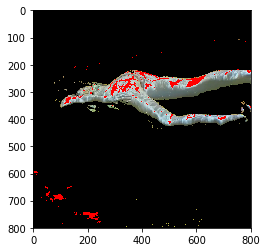

True

In [7]:
for item in list_pixels_first_order:
    # i and j are the coordinates of each first order pixel
    i = item.position[0]
    j = item.position[1]
    #print(sum(np.array(item.neighbors)))
    
    aux_rgb = (0,0,0)
    
    for neighbor in item.neighbors: 
        row = neighbor[0]
        col = neighbor[1]
        
        aux_rgb = aux_rgb + im_skin_interp[row,col]
    
    im_skin_interp[i,j] = aux_rgb/len(item.neighbors)
    print(aux_rgb)
    print(len(item.neighbors))
    print(im_skin_interp[i,j])
    
%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()

cv2.imwrite("temp_images/skin_color_interpolated_first_order_first_stage.png", im_skin_interp)


1.0


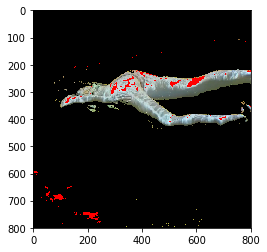

0.37863351177113913


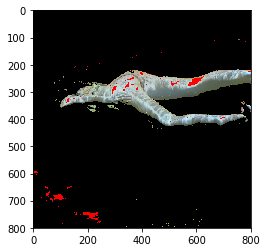

0.26823231451102286


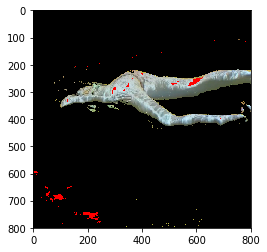

0.21038392908536235


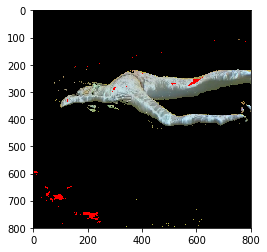

0.17912853278075175


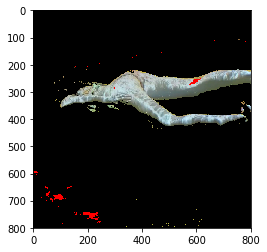

0.16163011569677085


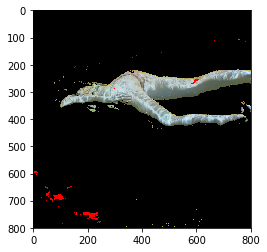

0.1517872560870316


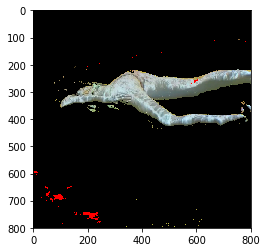

0.14539803142807806


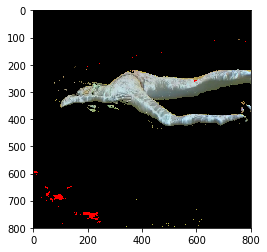

0.14165659356472687


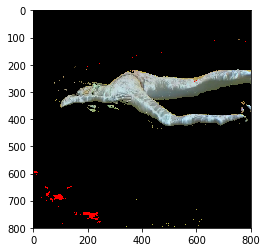

0.13946929142922926


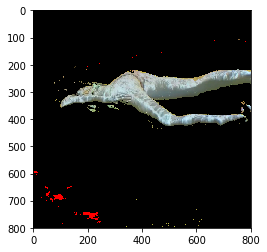

0.13860588269153284


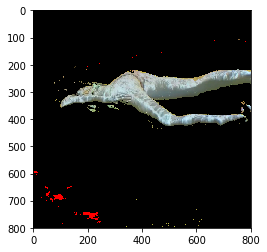

0.13860588269153284


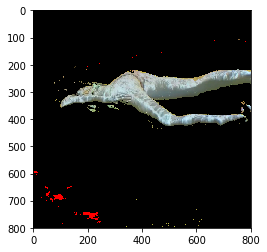

0.13860588269153284


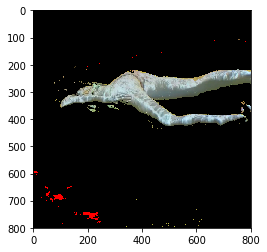

0.13860588269153284


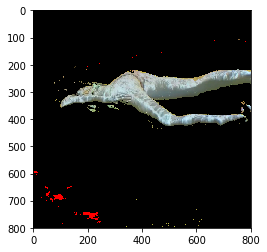

0.13860588269153284


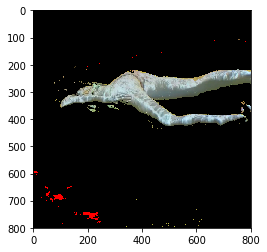

0.13860588269153284


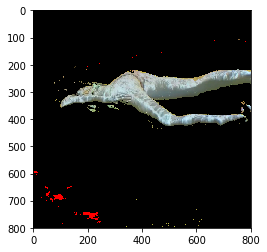

0.13860588269153284


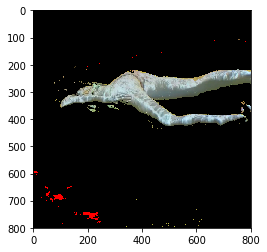

0.13860588269153284


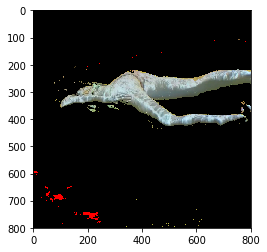

0.13860588269153284


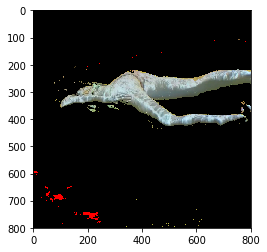

0.13860588269153284


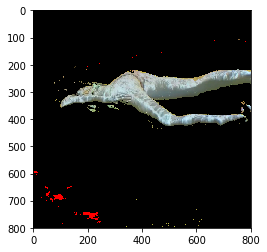

0.13860588269153284


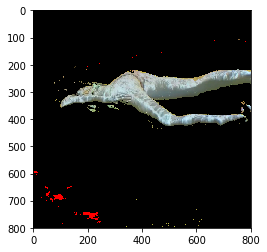

0.13860588269153284


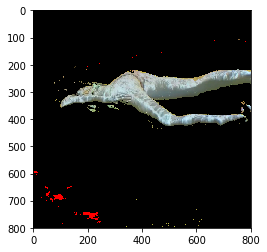

0.13860588269153284


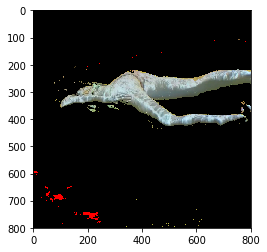

0.13860588269153284


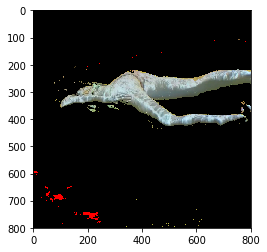

0.13860588269153284


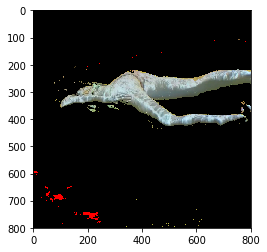

0.13860588269153284


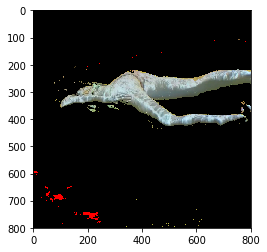

0.13860588269153284


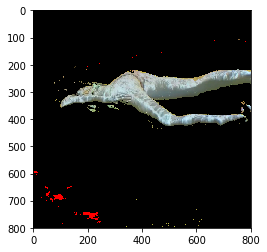

0.13860588269153284


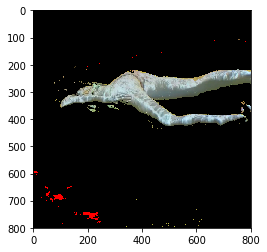

0.13860588269153284


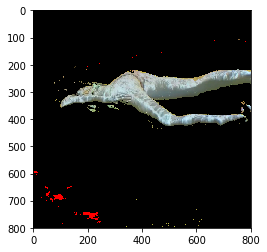

0.13860588269153284


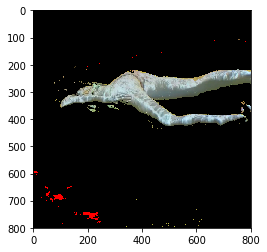

0.13860588269153284


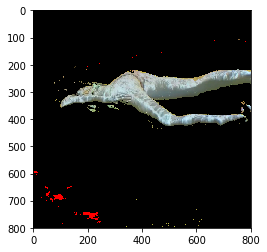

0.13860588269153284


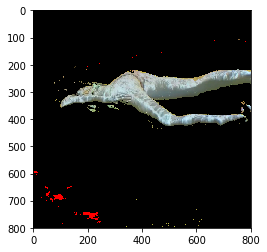

0.13860588269153284


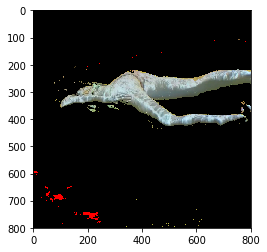

0.13860588269153284


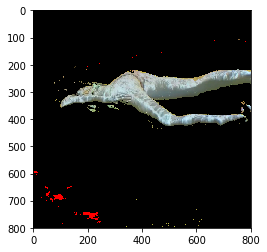

0.13860588269153284


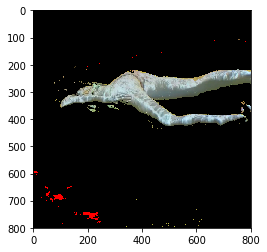

0.13860588269153284


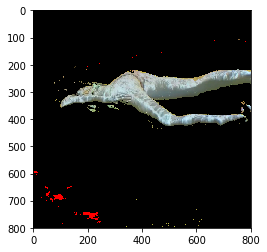

0.13860588269153284


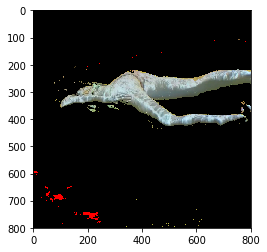

0.13860588269153284


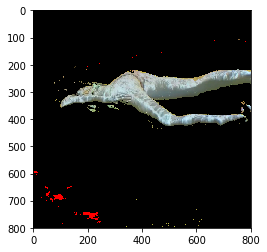

0.13860588269153284


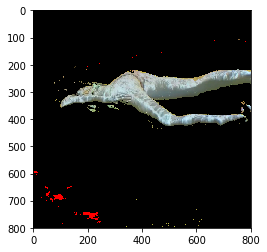

0.13860588269153284


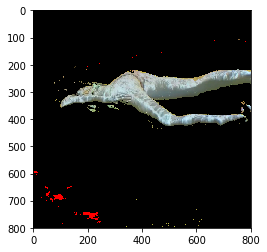

0.13860588269153284


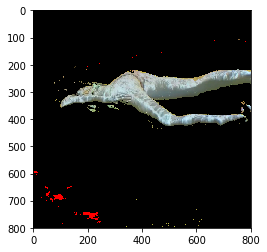

0.13860588269153284


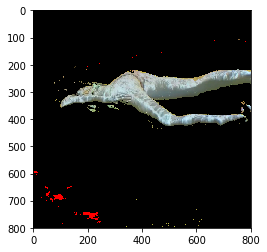

0.13860588269153284


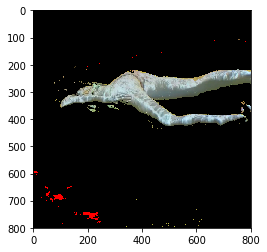

0.13860588269153284


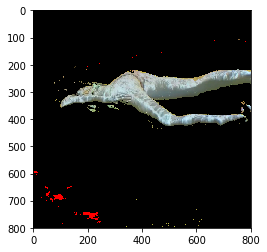

0.13860588269153284


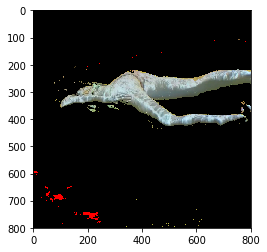

0.13860588269153284


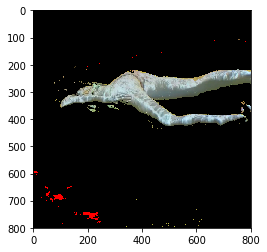

0.13860588269153284


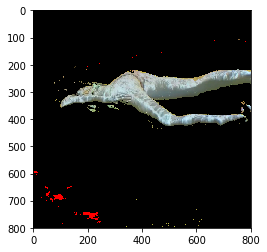

0.13860588269153284


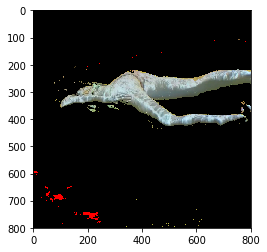

0.13860588269153284


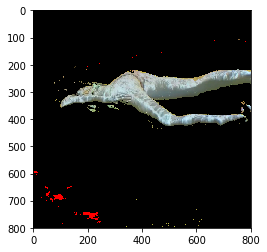

0.13860588269153284


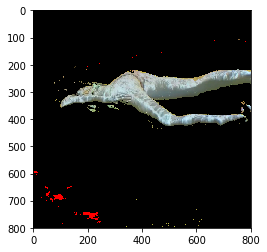

0.13860588269153284


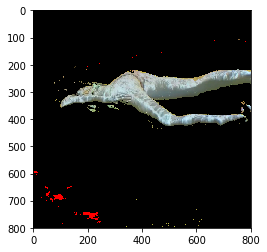

0.13860588269153284


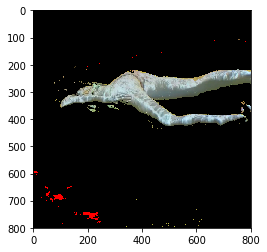

0.13860588269153284


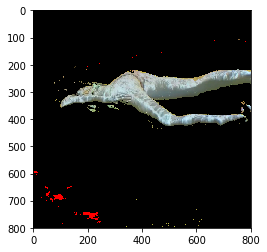

0.13860588269153284


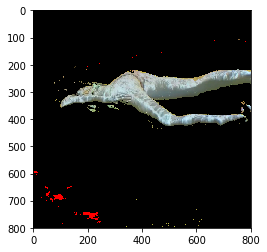

0.13860588269153284


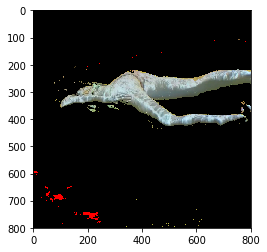

0.13860588269153284


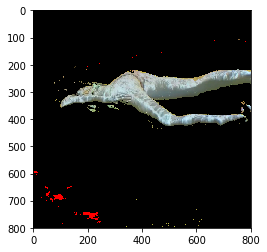

0.13860588269153284


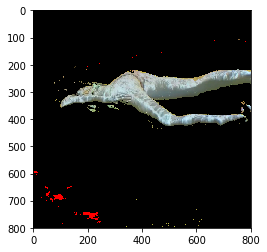

0.13860588269153284


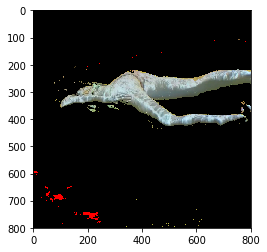

0.13860588269153284


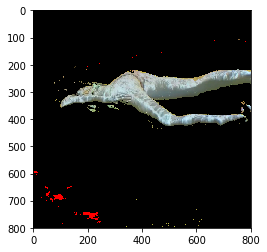

0.13860588269153284


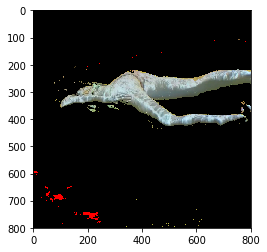

0.13860588269153284


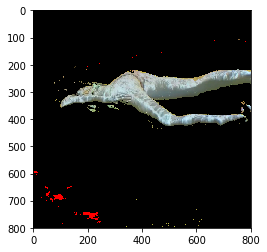

0.13860588269153284


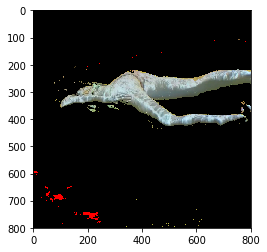

0.13860588269153284


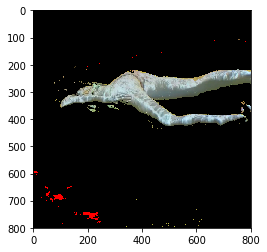

0.13860588269153284


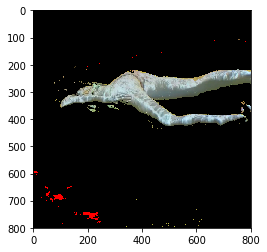

0.13860588269153284


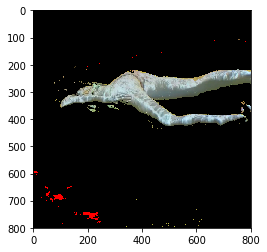

0.13860588269153284


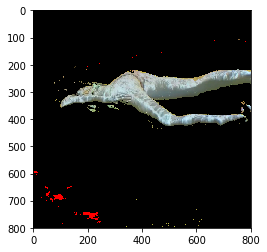

0.13860588269153284


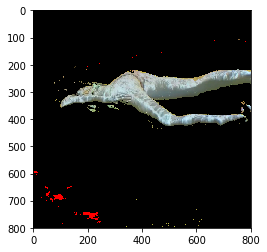

0.13860588269153284


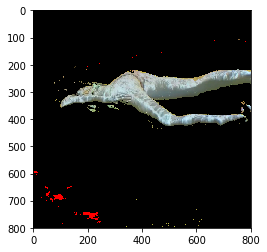

0.13860588269153284


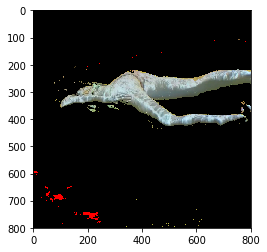

0.13860588269153284


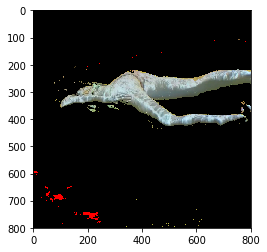

0.13860588269153284


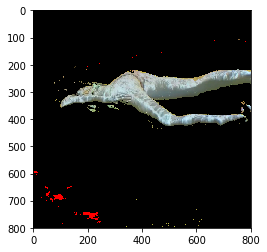

0.13860588269153284


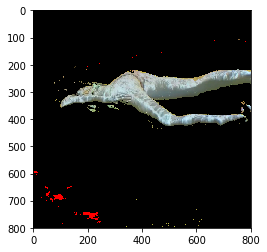

0.13860588269153284


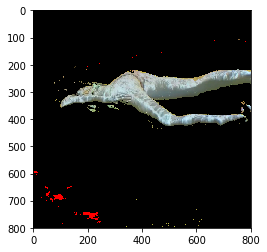

0.13860588269153284


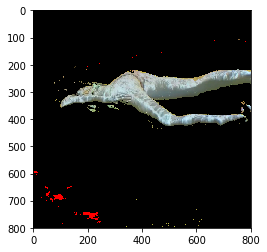

0.13860588269153284


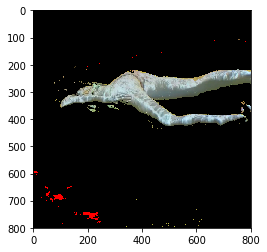

0.13860588269153284


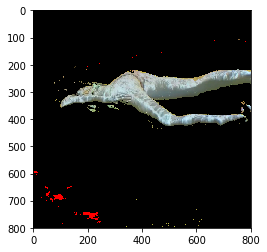

0.13860588269153284


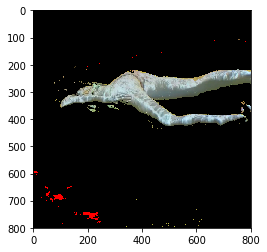

0.13860588269153284


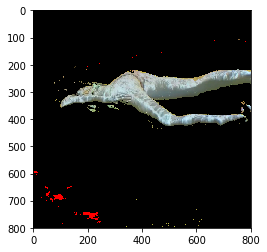

0.13860588269153284


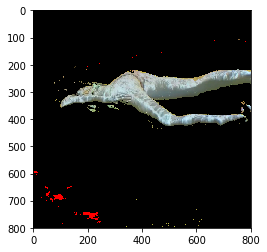

0.13860588269153284


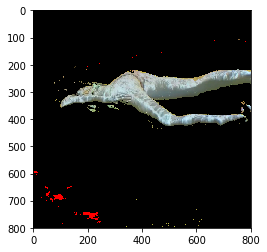

0.13860588269153284


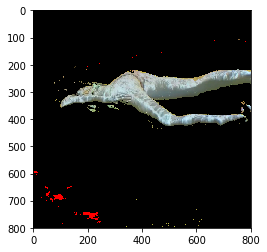

0.13860588269153284


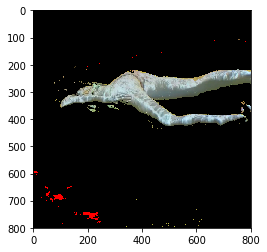

0.13860588269153284


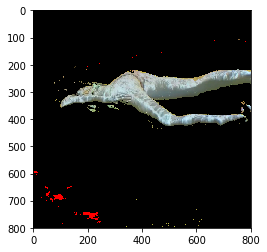

0.13860588269153284


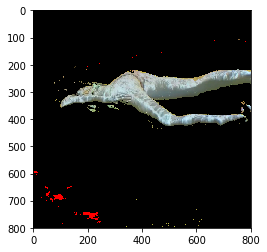

0.13860588269153284


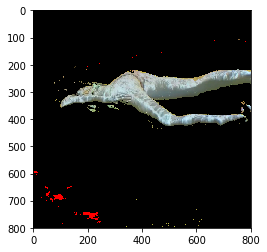

0.13860588269153284


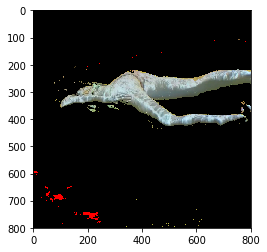

0.13860588269153284


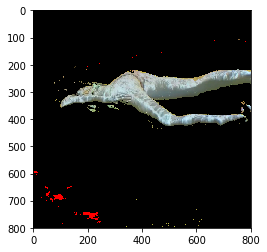

0.13860588269153284


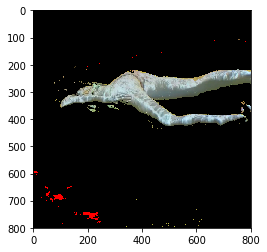

0.13860588269153284


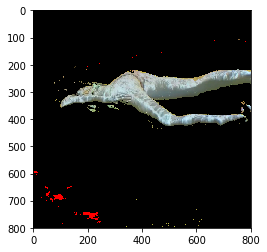

0.13860588269153284


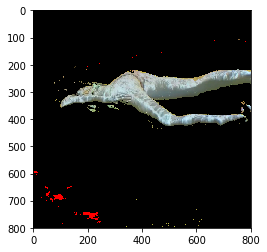

0.13860588269153284


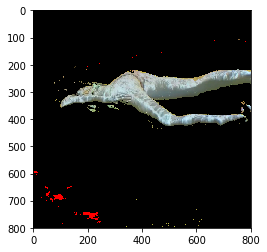

0.13860588269153284


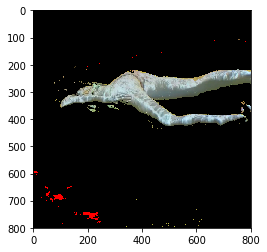

0.13860588269153284


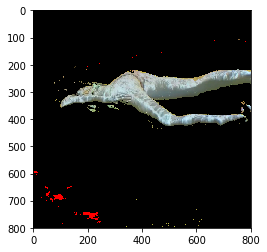

0.13860588269153284


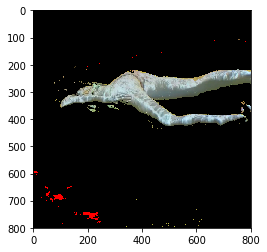

0.13860588269153284


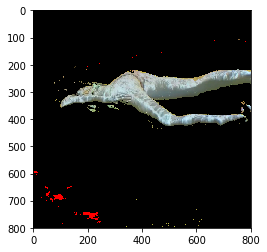

0.13860588269153284


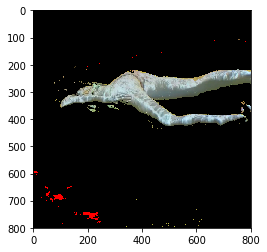

0.13860588269153284


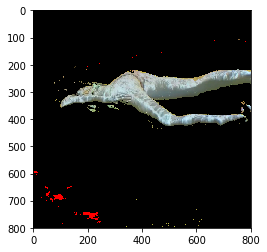

0.13860588269153284


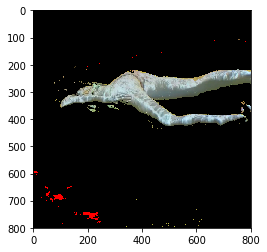

0.13860588269153284


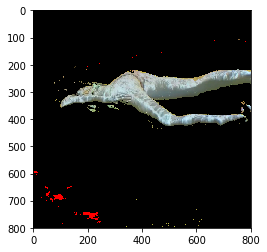

0.13860588269153284


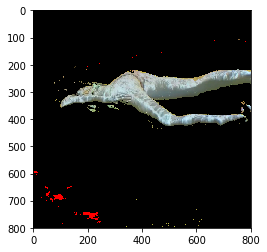

0.13860588269153284


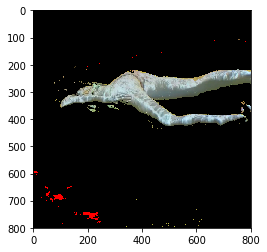

0.13860588269153284


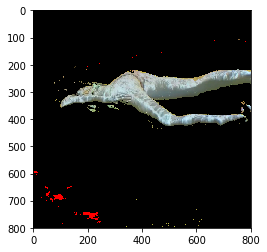

0.13860588269153284


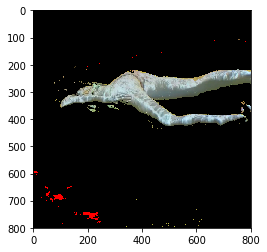

0.13860588269153284


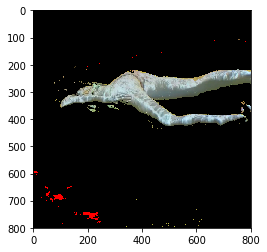

0.13860588269153284


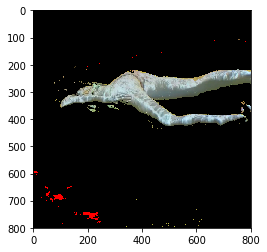

0.13860588269153284


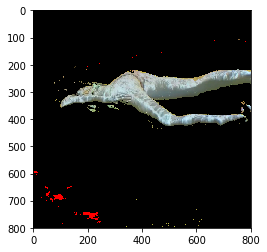

0.13860588269153284


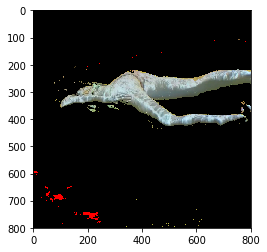

0.13860588269153284


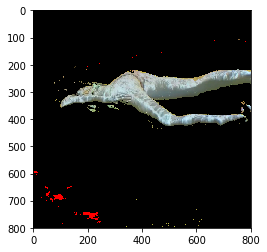

0.13860588269153284


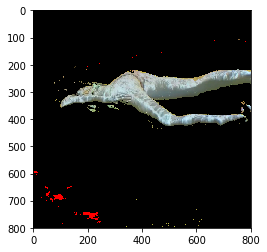

0.13860588269153284


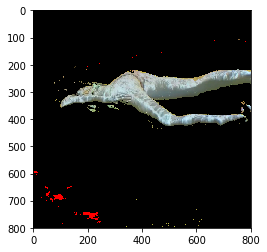

0.13860588269153284


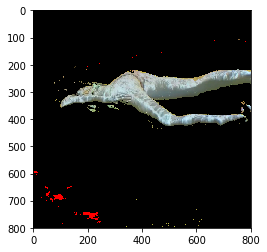

0.13860588269153284


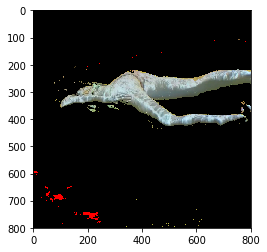

0.13860588269153284


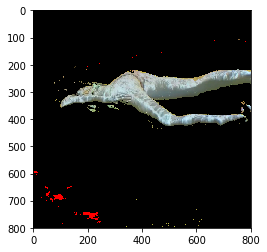

0.13860588269153284


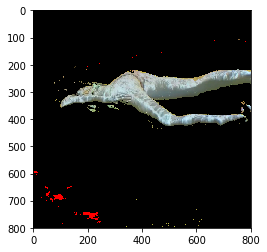

0.13860588269153284


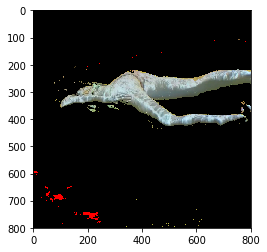

0.13860588269153284


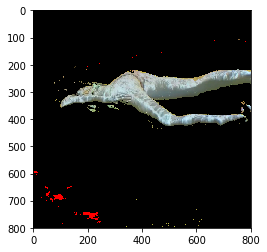

0.13860588269153284


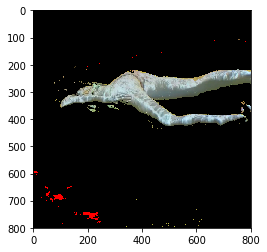

0.13860588269153284


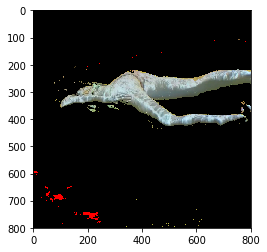

0.13860588269153284


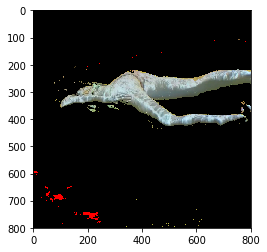

0.13860588269153284


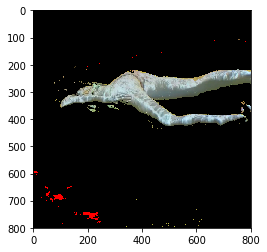

0.13860588269153284


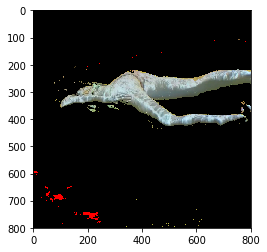

0.13860588269153284


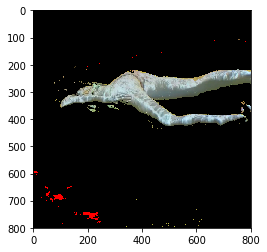

0.13860588269153284


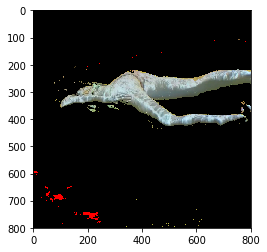

0.13860588269153284


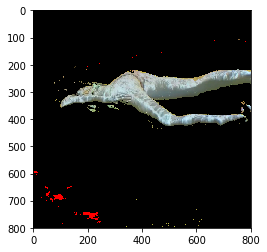

0.13860588269153284


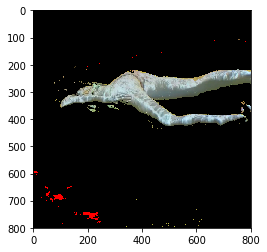

0.13860588269153284


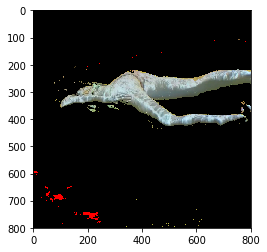

0.13860588269153284


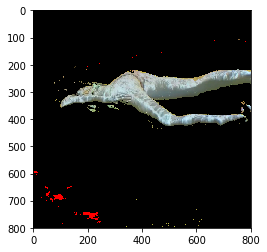

0.13860588269153284


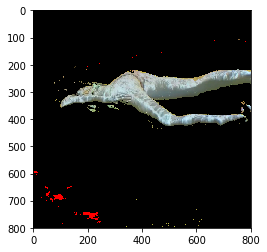

0.13860588269153284


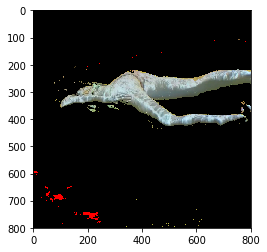

0.13860588269153284


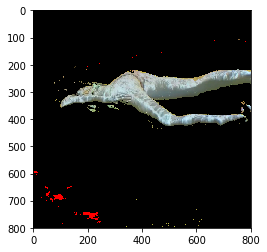

0.13860588269153284


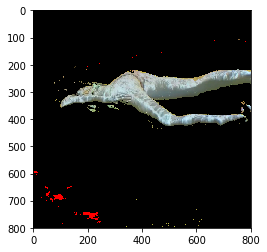

0.13860588269153284


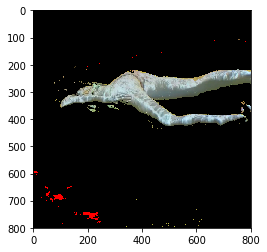

0.13860588269153284


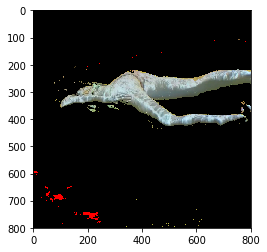

0.13860588269153284


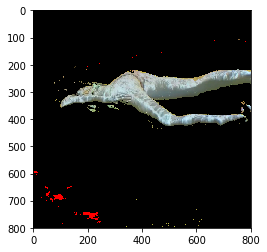

0.13860588269153284


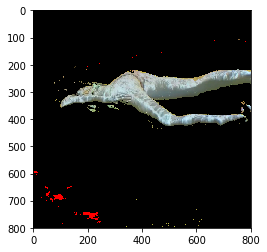

0.13860588269153284


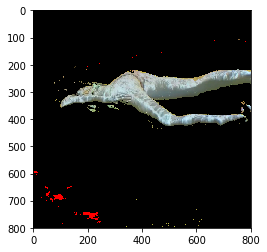

0.13860588269153284


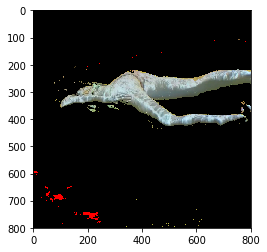

0.13860588269153284


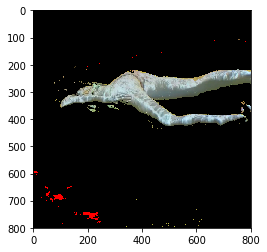

0.13860588269153284


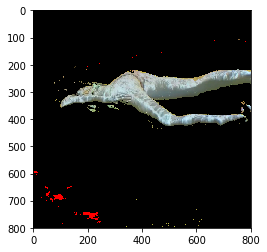

0.13860588269153284


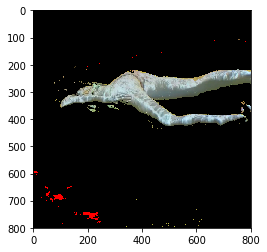

0.13860588269153284


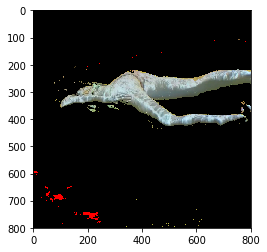

0.13860588269153284


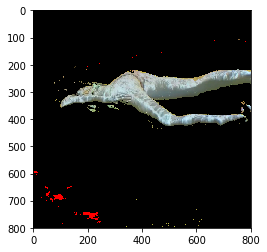

0.13860588269153284


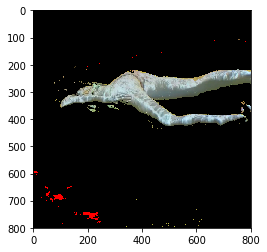

0.13860588269153284


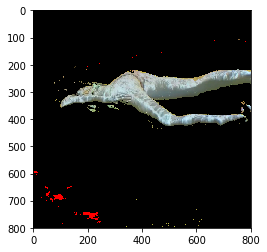

0.13860588269153284


KeyboardInterrupt: 

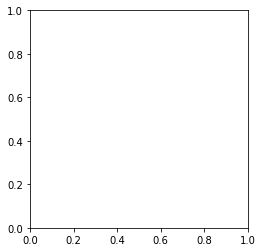

In [8]:
#Iterative method

num_total_pix_to_fix = len(list_pixels_to_fix)
num_current_pixels_to_fix = len(list_pixels_to_fix)
while True: 
    
    
    #Step 1: Find which pixels are first order pixels from those we still need to fix
    num_pixel = 0

    list_pixels_first_order = []
    print(num_current_pixels_to_fix/num_total_pix_to_fix)
    
    for item in list_pixels_to_fix: 
        
        # i and j are the coordinates of each red pixel
        i = item[0]
        j = item[1]
        
        initialization_pixel = 0 #That means that the pixel has not been added yet to the list of first order pixels
        
        for row in range(i-1, i+2):
            for col in range(j-1, j+2): 
                #Here it checks if some of the surrounding pixels are not equal to red (i.e. has skin color)
                if (im_skin_interp[row,col] != ([255,0,0])).all():
                    
                    if initialization_pixel == 0: 
                        #the first time, it is created a structure inside the list and the position is registered 
                        #the list of neighbors is initialized
                        list_pixels_first_order.append(num_pixel)
                        list_pixels_first_order[num_pixel] = Pixel()
                        list_pixels_first_order[num_pixel].position = (i,j)
                        list_pixels_first_order[num_pixel].neighbors = []
                        
                        initialization_pixel = 1
                        num_pixel = num_pixel + 1
                    
                    list_pixels_first_order[num_pixel-1].neighbors.append((row,col))
        
        initialization_pixel = 0   
        
        
    #Step 2: Interpolate those first order pixels
    
    for item in list_pixels_first_order:
        # i and j are the coordinates of each first order pixel
        i = item.position[0]
        j = item.position[1]
        #print(sum(np.array(item.neighbors)))

        aux_rgb = (0,0,0)

        for neighbor in item.neighbors: 
            row = neighbor[0]
            col = neighbor[1]

            aux_rgb = aux_rgb + im_skin_interp[row,col]

        im_skin_interp[i,j] = aux_rgb/len(item.neighbors)
        #print(aux_rgb)
        #print(len(item.neighbors))
        #print(im_skin_interp[i,j])
        
        list_pixels_to_fix.remove((i,j))

    num_current_pixels_to_fix = len(list_pixels_to_fix)
    
    #print(num_current_pixels_to_fix/num_total_pix_to_fix)
    
    %matplotlib inline
    dip.imshow(im_skin_interp)
    dip.show()
    cv2.imwrite("temp_images/skin_color_interpolated_first_order_last_stage.png", im_skin_interp)
    if len(list_pixels_to_fix) == []:
        break
        
    
%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()
    
    
cv2.imwrite("temp_images/skin_color_interpolated_first_order_last_stage.png", im_skin_interp)

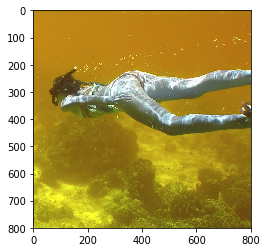

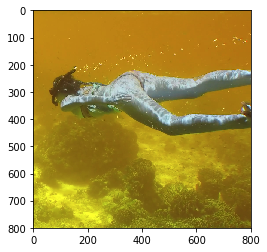

True

In [9]:
#Copying interpolated skin onto the original picture

im_res = np.copy(im_original)

%matplotlib inline
dip.imshow(im_original)
dip.show()

for i in range(np.shape(im_res)[0]):
    for j in range(np.shape(im_res)[1]):
        if (im_skin_interp[i,j] > [0, 0, 0]).all():
            im_res[i,j] = im_skin_interp[i,j]
            
%matplotlib inline
dip.imshow(im_res)
dip.show()

cv2.imwrite("temp_images/result.png", im_res)